In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

In [51]:
width = 28
height = 28
channels = 1
epochs = 15

img_shape = (width, height, channels)

In [52]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

In [53]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

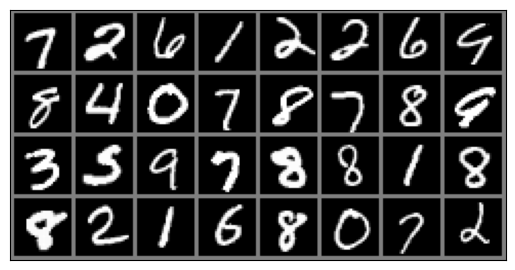

    7     2     6     1     2     2     6     9 
    8     4     0     7     8     7     8     9 
    3     5     9     7     8     8     1     8 
    8     2     1     6     8     0     7     2 


In [54]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

for j in range(batch_size):
    print('%5s' % labels[j].item(), end = ' ')
    if j % 8 == 7:
        print()

In [55]:
class Generator(nn.Module):
    def __init__(self, noise_dim = 100, img_dim = width * height * channels):
      super(Generator, self).__init__()
      self.model = nn.Sequential(
        nn.Linear(noise_dim, 256),
        nn.LeakyReLU(0.18),
        nn.BatchNorm1d(256, momentum = 0.8),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.18),
        nn.BatchNorm1d(512, momentum = 0.8),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.18),
        nn.BatchNorm1d(1024, momentum = 0.8),
        nn.Linear(1024, img_dim),
        nn.Tanh(),
      )

    def forward(self, x):
        x = self.model(x)
        output = x.view(-1, width, height, channels)
        return output

In [56]:
G = Generator().cuda()
summary(G, (100, ), batch_size = -1, device = 'cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
         LeakyReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 512]         131,584
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                 [-1, 1024]         525,312
         LeakyReLU-8                 [-1, 1024]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
           Linear-10                  [-1, 784]         803,600
             Tanh-11                  [-1, 784]               0
Total params: 1,489,936
Trainable params: 1,489,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [57]:
class Discriminator(nn.Module):
    
    def __init__(self, img_dim = width * height * channels):
      super(Discriminator, self).__init__()
        
      self.model = nn.Sequential(
          nn.Flatten(),
          nn.Linear(img_dim, img_dim),
          nn.LeakyReLU(0.18),
          nn.Linear(img_dim, img_dim // 2),
          nn.LeakyReLU(0.18),
          nn.Linear(img_dim // 2, 1),
          nn.Sigmoid(),
      )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        output = self.model(x)

        return output

D = Discriminator().cuda()
summary(D, img_shape, batch_size = -1, device = 'cuda')
print("_____________________ Discriminator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
         LeakyReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 392]         307,720
         LeakyReLU-5                  [-1, 392]               0
            Linear-6                    [-1, 1]             393
           Sigmoid-7                    [-1, 1]               0
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.52
Estimated Total Size (MB): 3.55
----------------------------------------------------------------
_____________________ Discriminator Created_____________________


In [60]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
weight_decay = 8e-8
epochs = 20

optimizer_G = optim.Adam(G.parameters(), lr = lr, betas = (beta1, beta2), weight_decay = weight_decay)
optimizer_D = optim.Adam(D.parameters(), lr = lr, betas = (beta1, beta2), weight_decay = weight_decay)

adversarial_loss = nn.BCELoss().cuda()

losses_G = []
losses_D = []
samples = []

In [61]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start = 1):

        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad = False)
        fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad = False)

        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

        optimizer_G.zero_grad()

        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))
        gen_imgs = G(z)
        
        g_loss = adversarial_loss(D(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i == len(trainloader):
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: % f]" 
                  % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
                 )

            losses_D.append(g_loss.item())
            losses_G.append(d_loss.item())
            samples.append(gen_imgs)

[Epoch 0/20] [Batch 1875/1875] [D loss: 0.567497] [G loss:  1.115005]
[Epoch 1/20] [Batch 1875/1875] [D loss: 0.524318] [G loss:  1.037344]
[Epoch 2/20] [Batch 1875/1875] [D loss: 0.707696] [G loss:  1.441001]
[Epoch 3/20] [Batch 1875/1875] [D loss: 0.556057] [G loss:  0.800447]
[Epoch 4/20] [Batch 1875/1875] [D loss: 0.539646] [G loss:  1.412727]
[Epoch 5/20] [Batch 1875/1875] [D loss: 0.535359] [G loss:  1.523408]
[Epoch 6/20] [Batch 1875/1875] [D loss: 0.569833] [G loss:  1.394598]
[Epoch 7/20] [Batch 1875/1875] [D loss: 0.608213] [G loss:  1.442288]
[Epoch 8/20] [Batch 1875/1875] [D loss: 0.511962] [G loss:  1.076298]
[Epoch 9/20] [Batch 1875/1875] [D loss: 0.473812] [G loss:  1.390771]
[Epoch 10/20] [Batch 1875/1875] [D loss: 0.616549] [G loss:  0.719332]
[Epoch 11/20] [Batch 1875/1875] [D loss: 0.536709] [G loss:  1.257222]
[Epoch 12/20] [Batch 1875/1875] [D loss: 0.524749] [G loss:  1.175117]
[Epoch 13/20] [Batch 1875/1875] [D loss: 0.494790] [G loss:  1.284784]
[Epoch 14/20] [B

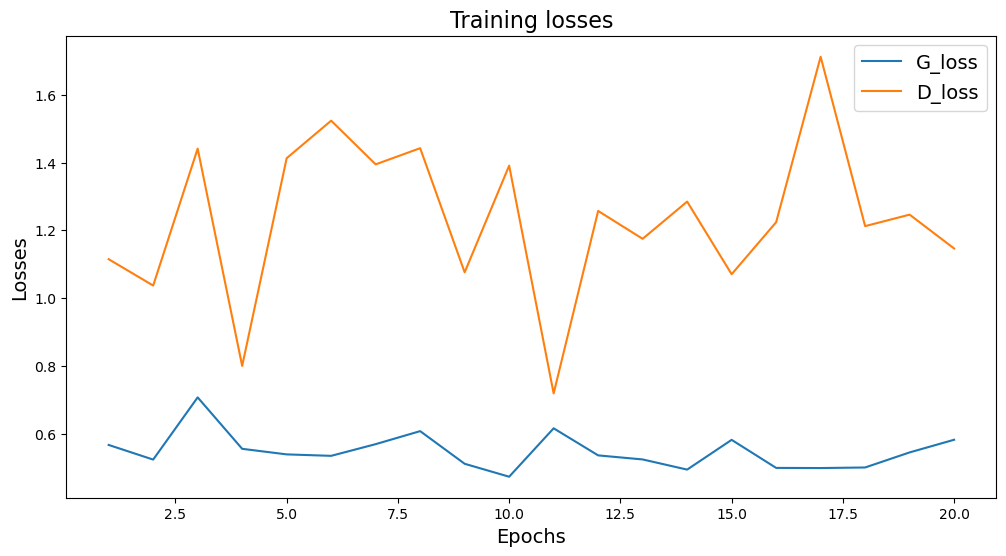

In [67]:
epochs_range = range(1, len(losses_G) + 1)

plt.figure(figsize = (12, 6))

plt.plot(epochs_range, losses_G, label = "G_loss")
plt.plot(epochs_range, losses_D, label = "D_loss")

plt.title("Training losses", fontsize = 16)
plt.legend(loc = "upper right", fontsize = 14)

plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Losses", fontsize = 14)

plt.show()

    ____________________ Step = 0 ____________________


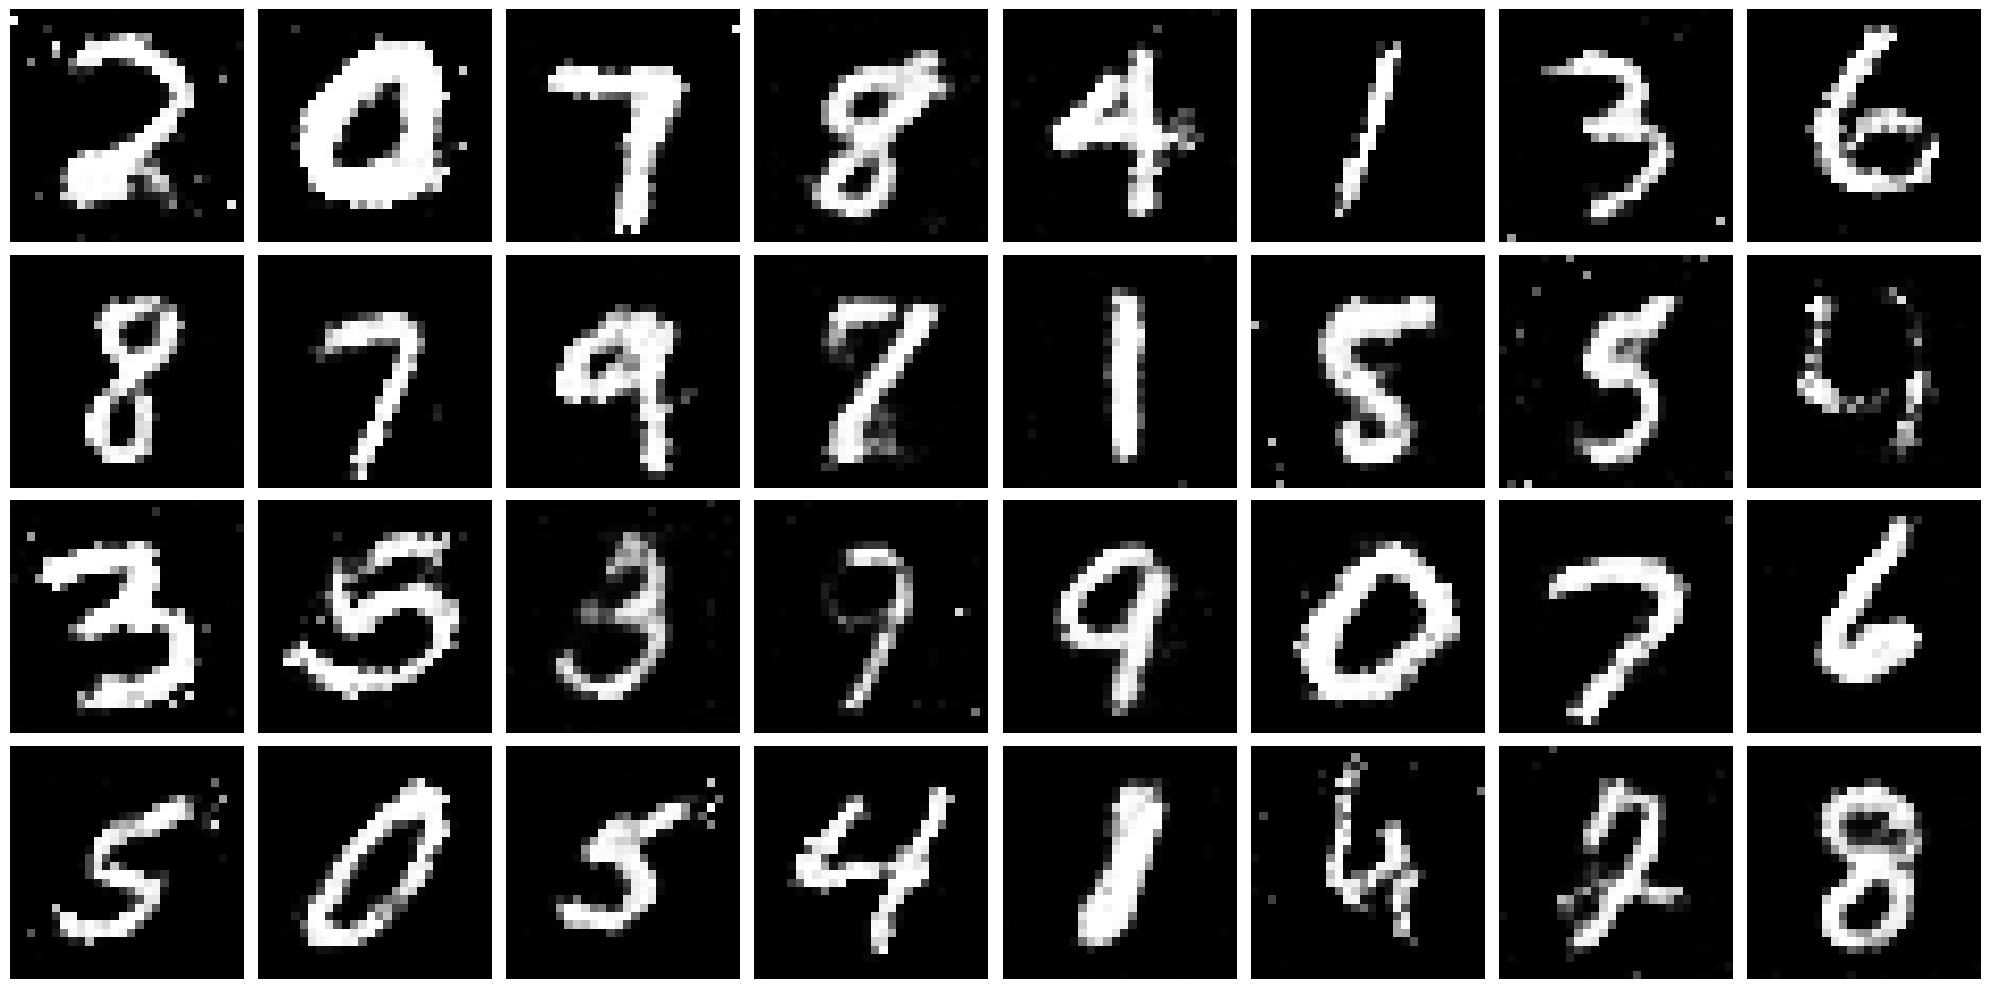



    ____________________ Step = 5 ____________________


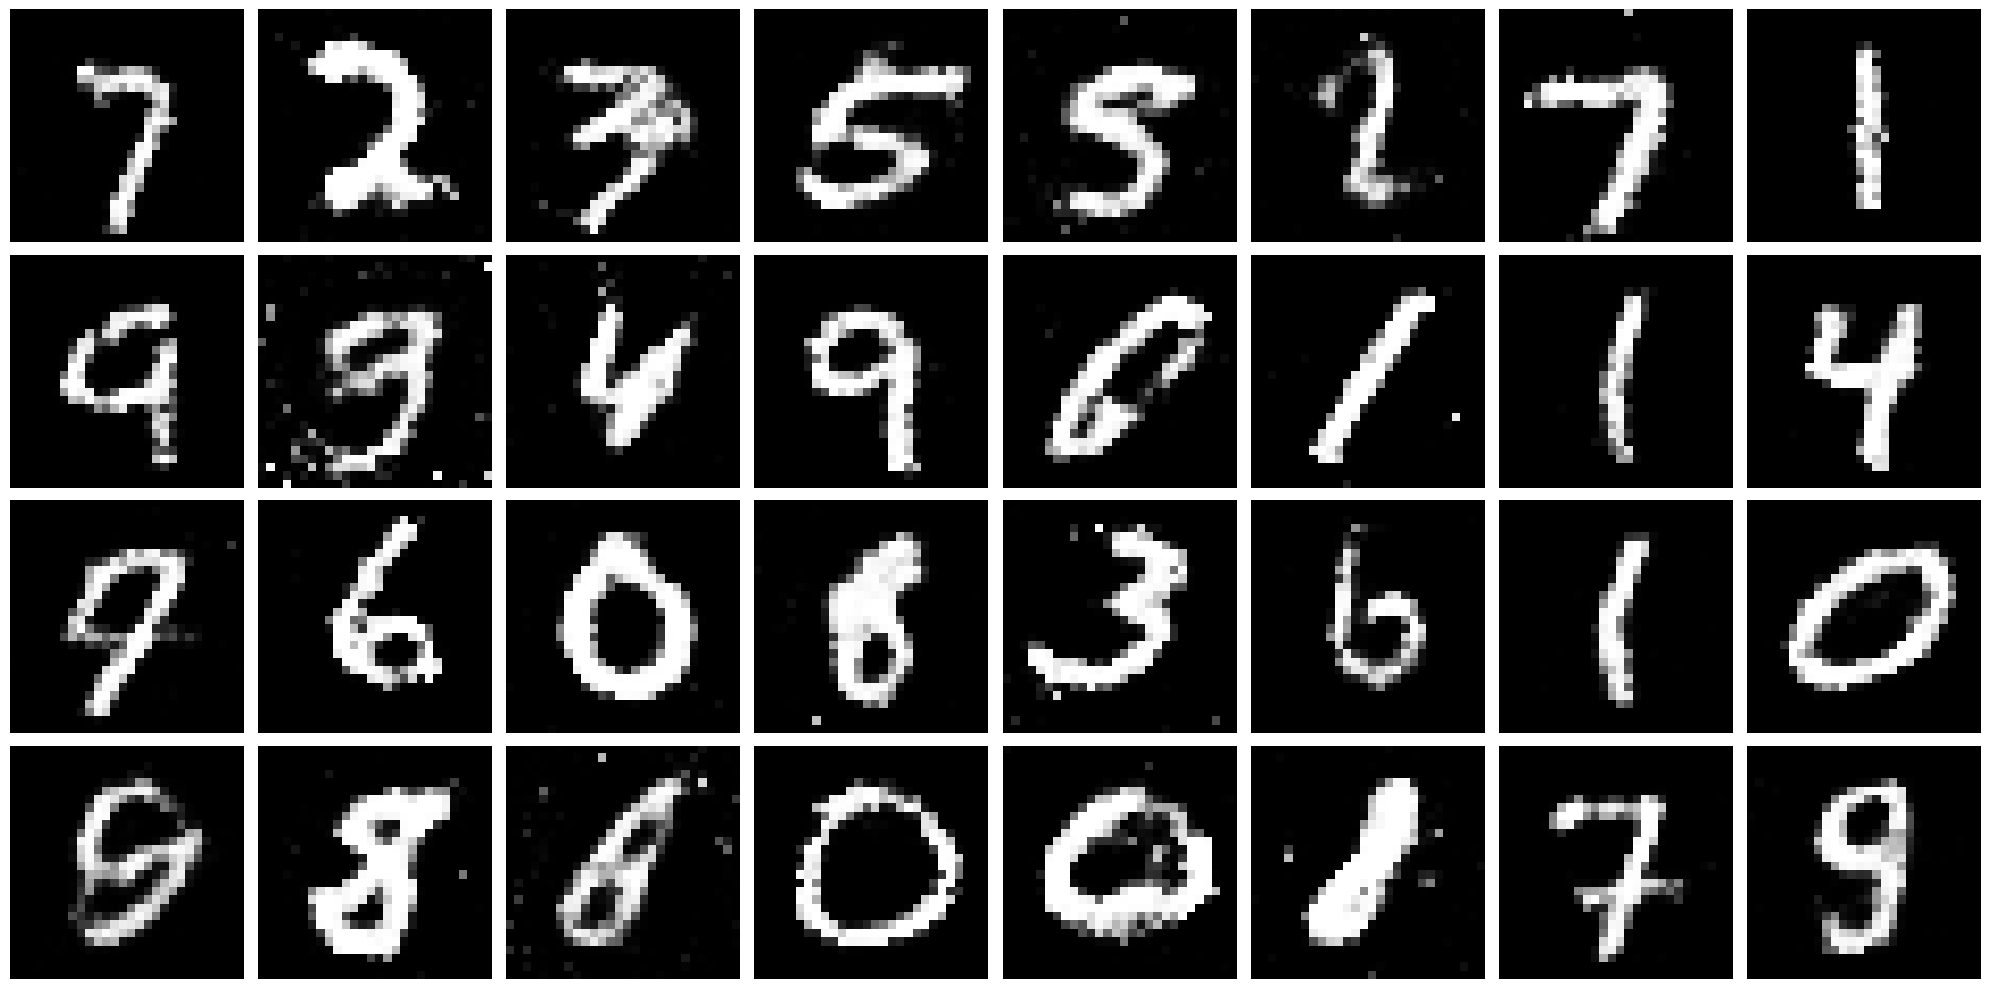



    ____________________ Step = 10 ____________________


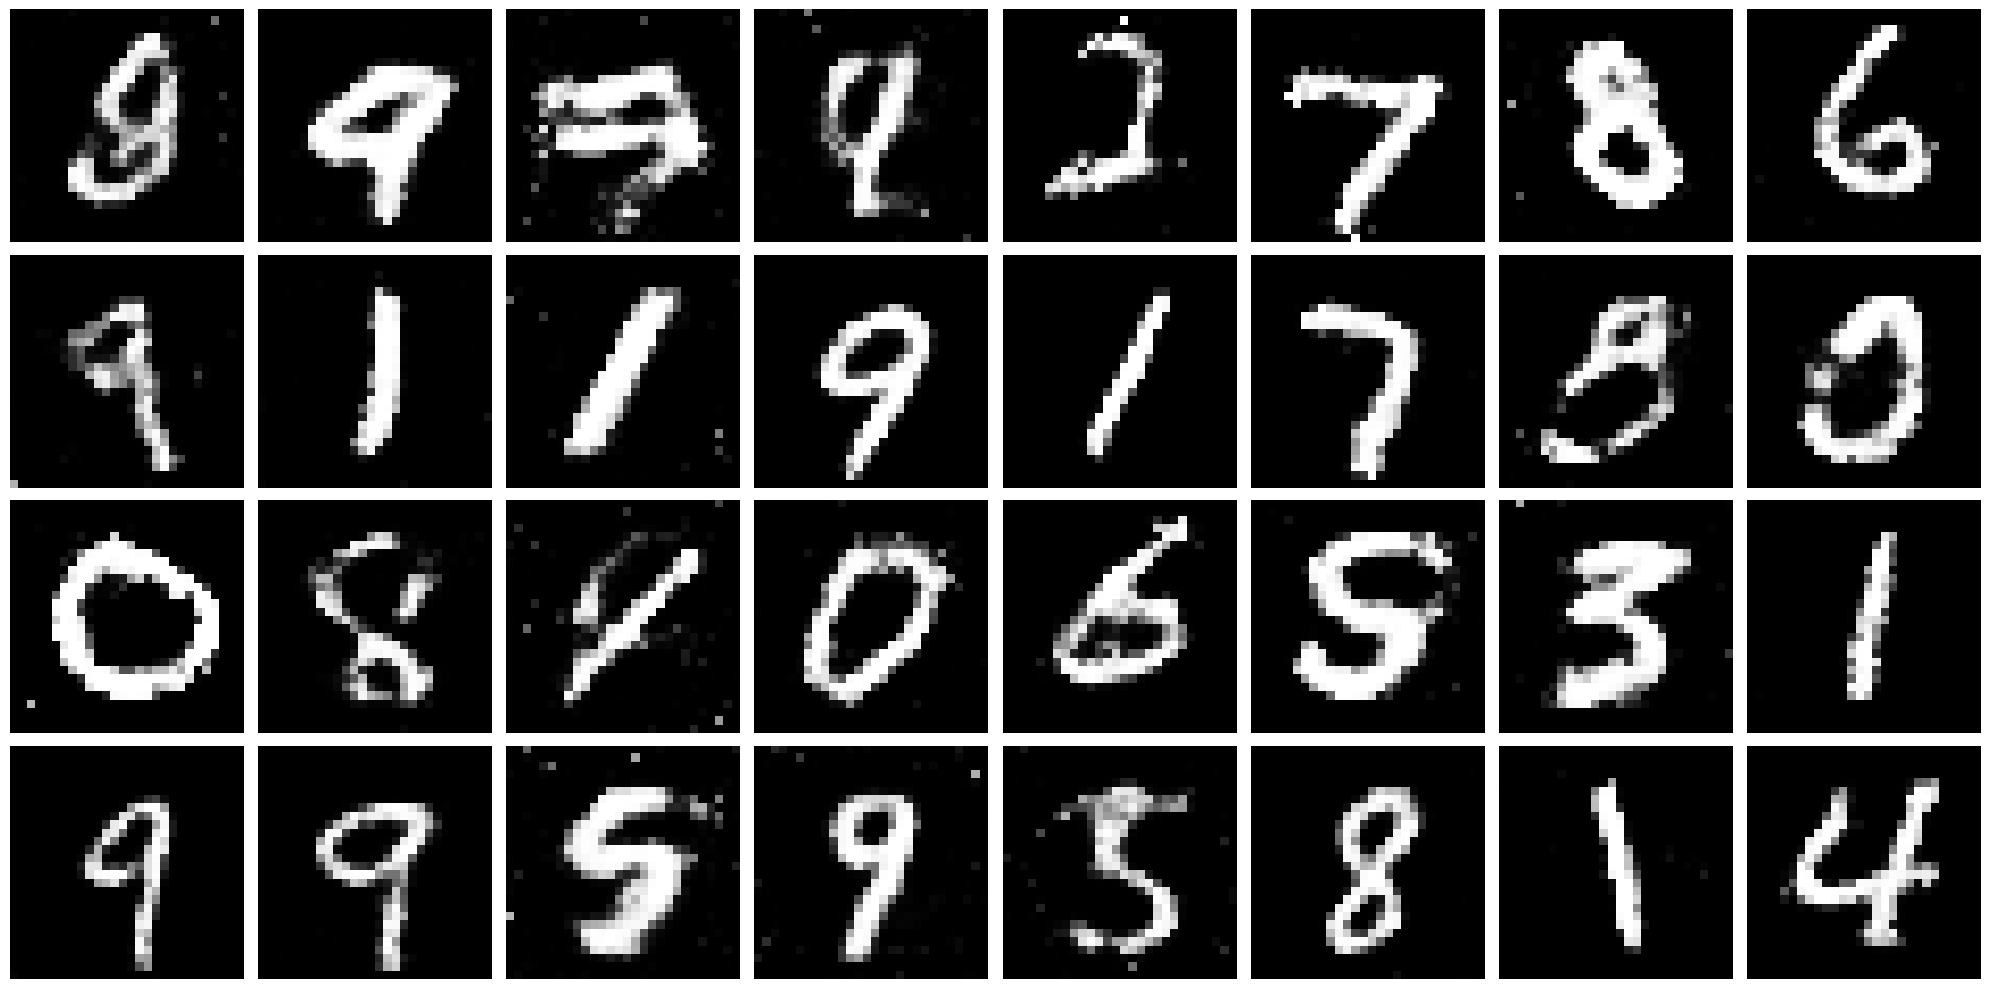



    ____________________ Step = 15 ____________________


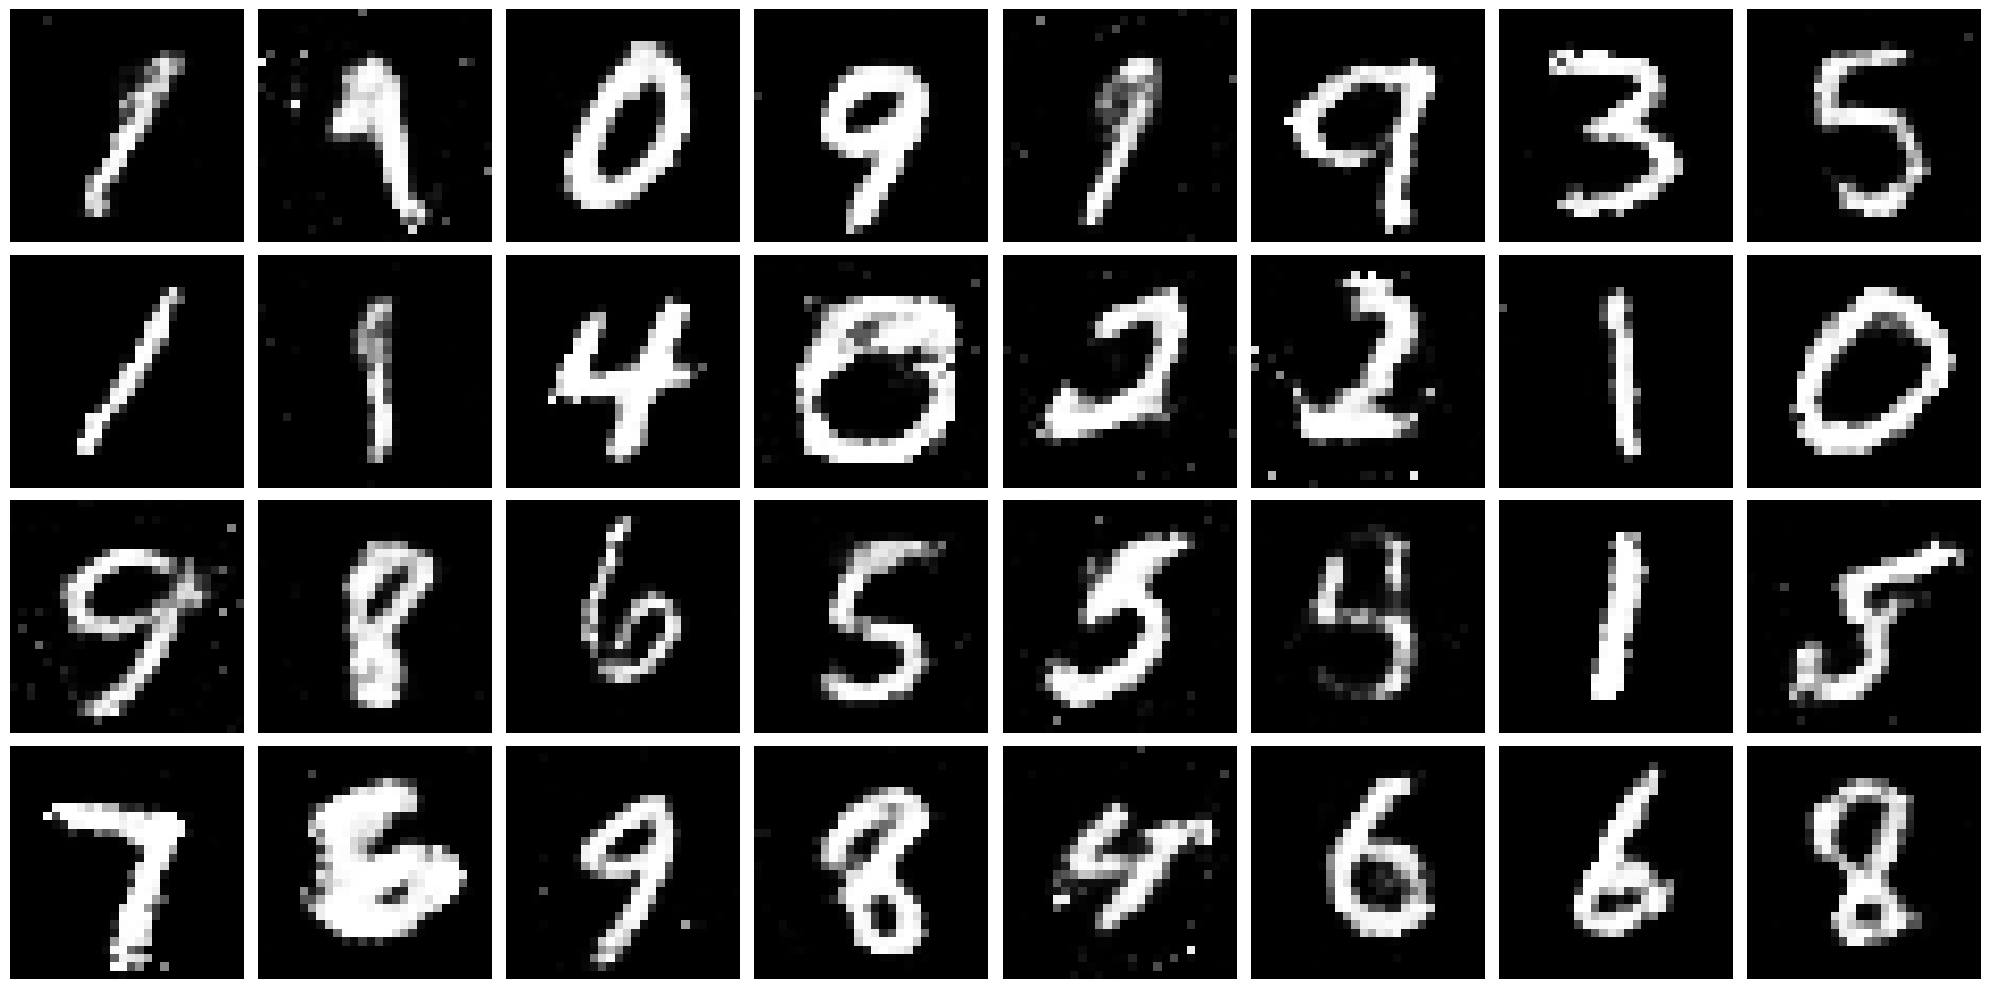

In [82]:
for idx in range(0, len(samples), 5):
    images = samples[idx].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % idx)
    
    plt.figure(figsize = (20, 10))
    
    for i in range(batch_size):
        plt.subplot(4, 8, i+1)
        image = images[i]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap = 'gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    print("\n")

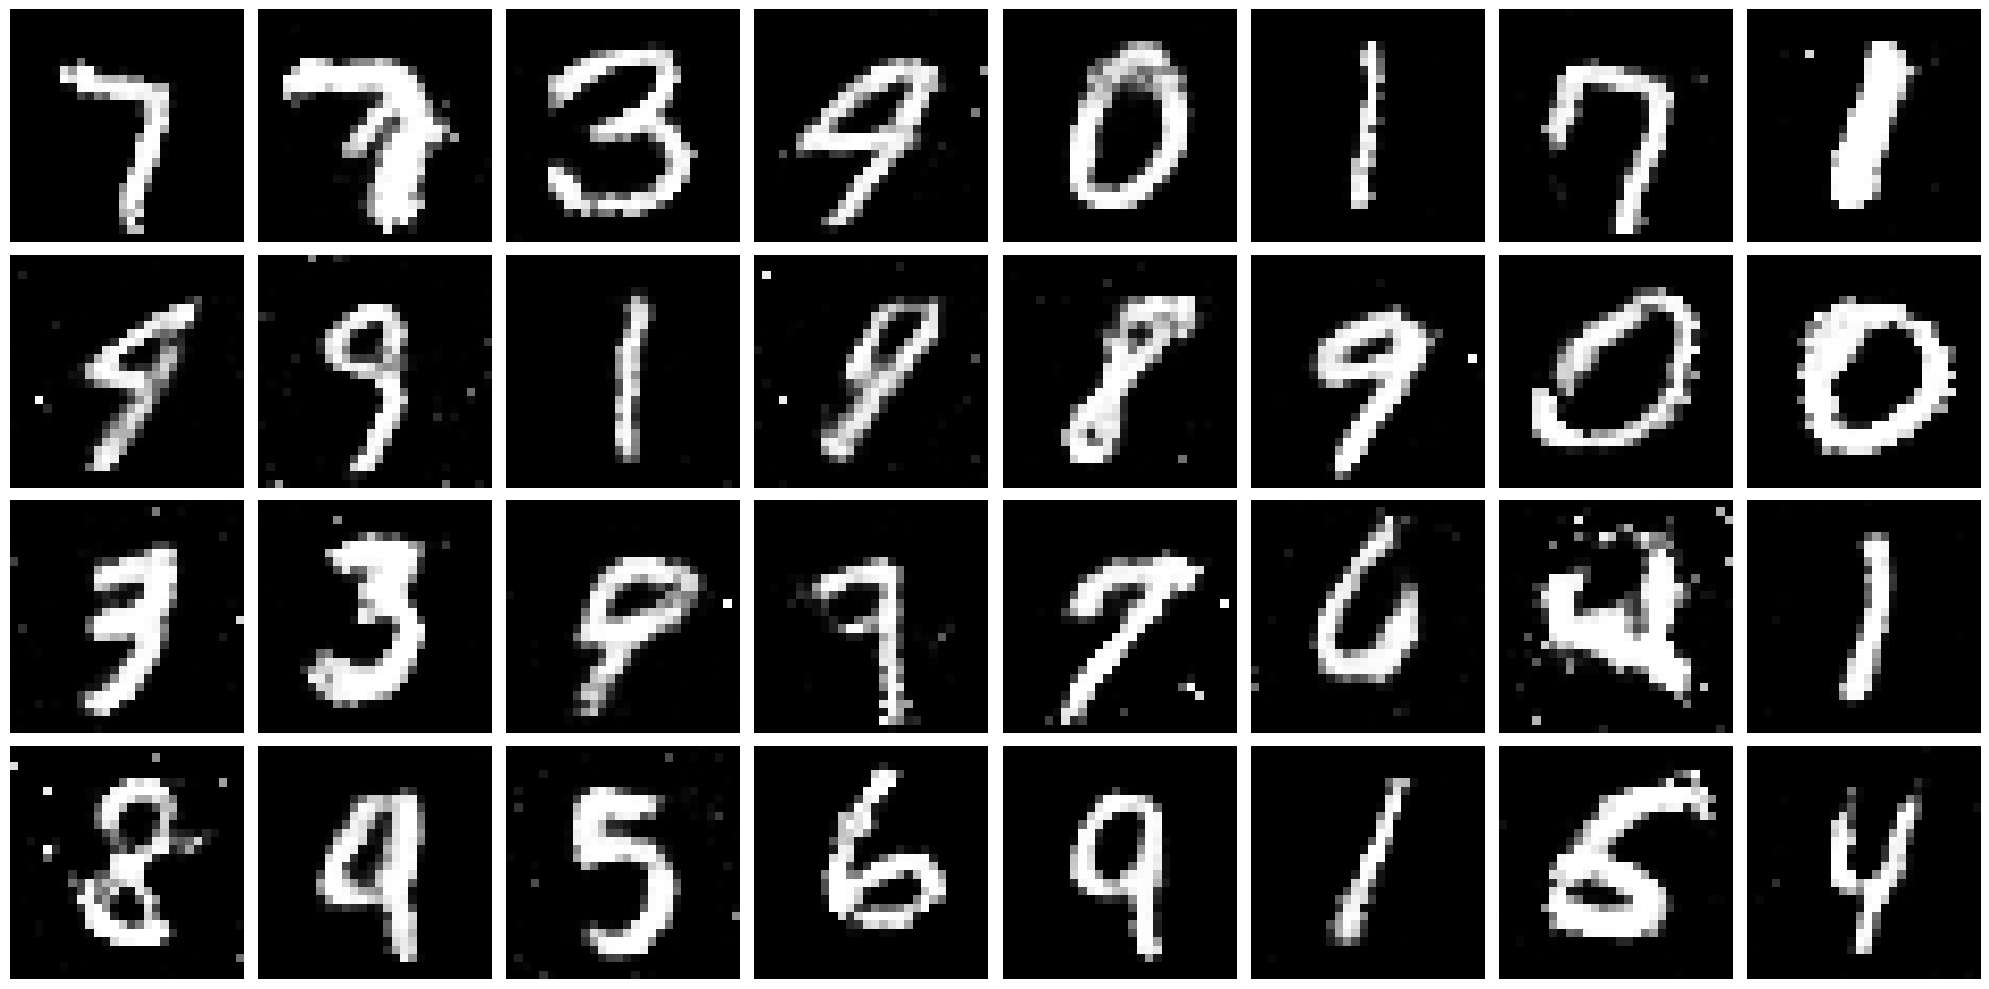

In [83]:
noise = torch.Tensor(np.random.normal(0, 1, (batch_size, 100))).cuda()
gen_images = G(noise)
images = gen_images.data.cpu().numpy()

plt.figure(figsize = (20, 10))

for i in range(batch_size):
    plt.subplot(4, 8, i + 1)
    image = images[i]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')

plt.tight_layout()
plt.show()